In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

# BreakHis Dataset


In [ ]:
# Download dataset:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

--2021-06-02 15:37:48--  http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz [following]
--2021-06-02 15:37:49--  https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/octet-stream]
Saving to: ‘BreaKHis_v1.tar.gz’

BreaKHis_v1.tar.gz  100%[===================>]   3.98G  23.1MB/s    in 3m 21s  

2021-06-02 15:41:11 (20.3 MB/s) - ‘BreaKHis_v1.tar.gz’ saved [4273561758/4273561758]



In [ ]:
!tar -xzvf BreaKHis_v1.tar.gz > /dev/null

In [ ]:
%rm -rf augmented

In [ ]:
# Creating two folders for two classes
import os
os.mkdir('augmented')
os.mkdir('augmented/benign')
os.mkdir('augmented/malignant')

In [ ]:
# Getting list of files from dataset
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [ ]:
# Copying files to the two folders
import shutil
files_benign=getListOfFiles('/content/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')
files_malignant=getListOfFiles('/content/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [ ]:
# Storing list of images in two folders
benign=getListOfFiles('augmented/benign')
malignent=getListOfFiles('augmented/malignant')

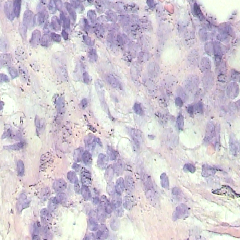

In [ ]:
from keras.preprocessing import image
image.load_img(benign[5], target_size=(240,240,1), grayscale=False)

In [ ]:
len(benign)

2480

In [ ]:
len(malignent)

5429

In [ ]:
# Converting images to nd.array and storing in X 
X = []
Y = []
from tqdm import tqdm
for i in tqdm(benign):
  img = image.load_img(i, target_size=(128,128,3))
  img = image.img_to_array(img)
  img = img/255
  X.append(img)
  Y.append('0')
for i in tqdm(malignent):
  img = image.load_img(i, target_size=(128,128,3))
  img = image.img_to_array(img)
  img = img/255
  X.append(img)
  Y.append('1')

100%|██████████| 5429/5429 [01:07<00:00, 80.26it/s]


In [ ]:
import numpy as np
X = np.array(X)
X.shape

(7909, 128, 128, 3)

In [ ]:
Y = [int(i) for i in Y]
Y = np.array(Y)

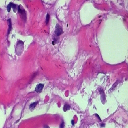

In [ ]:
image.array_to_img(X[1])

In [ ]:
# Creating testing training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.1, shuffle=True)

In [ ]:
# Encoding labels
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)
Y_val = np_utils.to_categorical(Y_val, 2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(6406, 128, 128, 3)
(791, 128, 128, 3)
(712, 128, 128, 3)


In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9da9e67d-7087-b26d-497d-12c653a4f7c7)


In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
optimizer = tf.keras.optimizers.SGD(
          learning_rate=0.001)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001, verbose=1)

# ResNet50

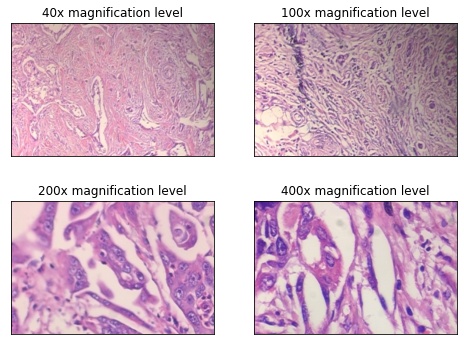

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

arr = ['40','100','200','400']
plt.figure(figsize=(8,6))
for i, j in enumerate(arr):
  plt.subplot(2,2,i+1)
  img = mpimg.imread('/content/augmented/malignant/SOB_M_DC-14-10926-'+j+'-001.png')
  plt.imshow(img)
  ax = plt.gca()
  ax.axes.xaxis.set_ticks([])
  ax.axes.yaxis.set_ticks([])
  plt.title(j+'x magnification level')

plt.show()

##Fine Tuned

In [ ]:
# Using ResNet50
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(
    include_top=None,
    weights='imagenet',
    input_shape=(128,128,3))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
for i, layer in enumerate(resnet.layers):
  print(i,layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
# Freezing few upper layers
for layer in resnet.layers[:143]:
  layer.trainable=False

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Sequential

resnet50 = Sequential()
resnet50.add(resnet)
resnet50.add(Flatten())   # flatten output of conv
resnet50.add(BatchNormalization())
resnet50.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 128 neuron
resnet50.add(Dropout(0.5))
resnet50.add(BatchNormalization())
resnet50.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
resnet50.add(Dropout(0.5))
resnet50.add(Dense(2, activation='softmax'))  # output layer

In [ ]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [ ]:
resnet50.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_2 = resnet50.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 51s 73ms/step - loss: 0.9282 - accuracy: 0.5233 - val_loss: 0.6743 - val_accuracy: 0.7121
Epoch 2/100
201/201 [==============================] - 12s 59ms/step - loss: 0.7721 - accuracy: 0.6107 - val_loss: 0.6812 - val_accuracy: 0.6166
Epoch 3/100
201/201 [==============================] - 12s 60ms/step - loss: 0.7356 - accuracy: 0.6404 - val_loss: 0.5996 - val_accuracy: 0.7275
Epoch 4/100
201/201 [==============================] - 12s 60ms/step - loss: 0.6715 - accuracy: 0.6901 - val_loss: 0.7877 - val_accuracy: 0.4537
Epoch 5/100
201/201 [==============================] - 12s 60ms/step - loss: 0.6565 - accuracy: 0.6942 - val_loss: 0.5373 - val_accuracy: 0.7711
Epoch 6/100
201/201 [==============================] - 12s 61ms/step - loss: 0.6101 - accuracy: 0.7261 - val_loss: 0.7476 - val_accuracy: 0.7149
Epoch 7/100
201/201 [==============================] - 12s 62ms/step - loss: 0.6090 - accuracy: 0.7270 - val_loss: 0.6052 - val_ac

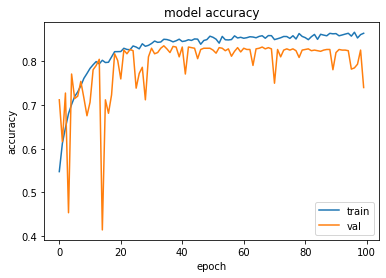

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

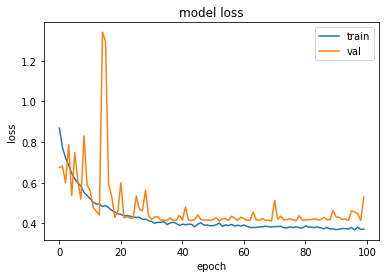

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
resnet50.evaluate(X_test, Y_test)

25/25 [==============================] - 1s 59ms/step - loss: 0.5205 - accuracy: 0.7396


[0.5205055475234985, 0.739570140838623]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = resnet50.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.86      0.55      0.67       381
   malignant       0.69      0.92      0.78       410

    accuracy                           0.74       791
   macro avg       0.77      0.73      0.73       791
weighted avg       0.77      0.74      0.73       791



In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))

array([[209, 172],
       [ 34, 376]])

##Fully Trained

In [ ]:
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_shape=(128,128,3))

In [ ]:
resnet50 = Sequential()
resnet50.add(resnet)
resnet50.add(Flatten())   # flatten output of conv
resnet50.add(BatchNormalization())
resnet50.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 128 neuron
resnet50.add(Dropout(0.5))
resnet50.add(BatchNormalization())
resnet50.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
resnet50.add(Dropout(0.5))
resnet50.add(Dense(2, activation='softmax'))  # output layer

In [ ]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [ ]:
resnet50.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_2 = resnet50.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 66s 144ms/step - loss: 0.6153 - accuracy: 0.7392 - val_loss: 0.6603 - val_accuracy: 0.7107
Epoch 2/100
201/201 [==============================] - 27s 132ms/step - loss: 0.5193 - accuracy: 0.7865 - val_loss: 0.3805 - val_accuracy: 0.8539
Epoch 3/100
201/201 [==============================] - 27s 132ms/step - loss: 0.4352 - accuracy: 0.8284 - val_loss: 0.3793 - val_accuracy: 0.8581
Epoch 4/100
201/201 [==============================] - 26s 130ms/step - loss: 0.4030 - accuracy: 0.8408 - val_loss: 0.6967 - val_accuracy: 0.7809
Epoch 5/100
201/201 [==============================] - 26s 131ms/step - loss: 0.4022 - accuracy: 0.8326 - val_loss: 0.3594 - val_accuracy: 0.8469
Epoch 6/100
201/201 [==============================] - 26s 131ms/step - loss: 0.3945 - accuracy: 0.8355 - val_loss: 0.4076 - val_accuracy: 0.8118

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/100
201/201 [=======================

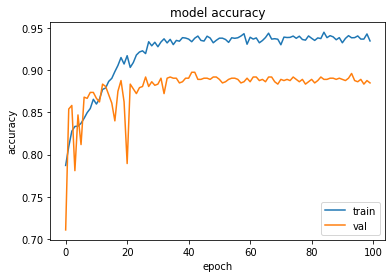

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

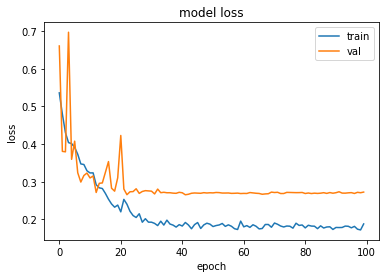

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
resnet50.evaluate(X_test, Y_test)

25/25 [==============================] - 2s 60ms/step - loss: 0.2310 - accuracy: 0.9140


[0.23101511597633362, 0.9140328764915466]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = resnet50.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.88      0.84      0.86       255
   malignant       0.93      0.95      0.94       536

    accuracy                           0.91       791
   macro avg       0.91      0.90      0.90       791
weighted avg       0.91      0.91      0.91       791



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1)))

[[215  40]
 [ 28 508]]


# AlexNet

In [ ]:
alexnet = Sequential()
alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
alexnet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(2, activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.SGD(
          learning_rate=0.01)

In [ ]:
alexnet.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_3 = alexnet.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 7s 29ms/step - loss: 0.6501 - accuracy: 0.7635 - val_loss: 0.7919 - val_accuracy: 0.7121
Epoch 2/100
201/201 [==============================] - 5s 26ms/step - loss: 0.4124 - accuracy: 0.8295 - val_loss: 1.0003 - val_accuracy: 0.7121
Epoch 3/100
201/201 [==============================] - 5s 27ms/step - loss: 0.4090 - accuracy: 0.8272 - val_loss: 1.1569 - val_accuracy: 0.7121
Epoch 4/100
201/201 [==============================] - 5s 27ms/step - loss: 0.3463 - accuracy: 0.8510 - val_loss: 3.1425 - val_accuracy: 0.7121

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/100
201/201 [==============================] - 5s 27ms/step - loss: 0.3603 - accuracy: 0.8398 - val_loss: 2.2059 - val_accuracy: 0.7121
Epoch 6/100
201/201 [==============================] - 5s 27ms/step - loss: 0.3082 - accuracy: 0.8702 - val_loss: 2.2308 - val_accuracy: 0.7163
Epoch 7/100
201/201 [==============================] - 5

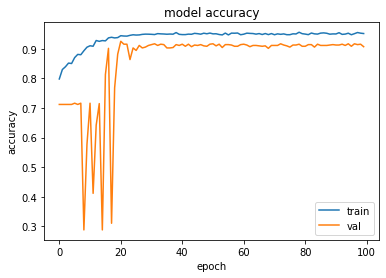

In [ ]:
# Performance of AlexNet on BreakHis 
import matplotlib.pyplot as plt
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

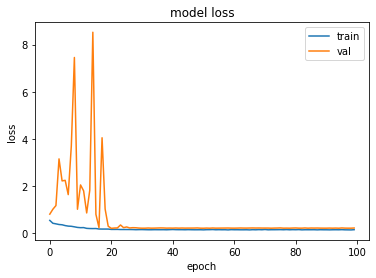

In [ ]:
# Performance of AlexNet on BreakHis 
import matplotlib.pyplot as plt
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
alexnet.evaluate(X_test,Y_test)

25/25 [==============================] - 1s 28ms/step - loss: 0.1603 - accuracy: 0.9305


[0.16027145087718964, 0.9304677844047546]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = alexnet.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.87      0.90      0.89       236
   malignant       0.96      0.94      0.95       555

    accuracy                           0.93       791
   macro avg       0.91      0.92      0.92       791
weighted avg       0.93      0.93      0.93       791



In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))

array([[212,  24],
       [ 31, 524]])

# Inception


##Fine Tuned

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(inception_v3.layers):
  print(i,layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freezing few upper layers
for layer in inception_v3.layers[:249]:
  layer.trainable=False

In [ ]:
inception = Sequential()
inception.add(inception_v3)
inception.add(Flatten())   # flatten output of conv
inception.add(BatchNormalization())
inception.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 128 neuron
inception.add(Dropout(0.5))
inception.add(BatchNormalization())
inception.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
inception.add(Dropout(0.5))
inception.add(Dense(2, activation='softmax'))  # output layer

In [ ]:
inception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [ ]:
optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
inception.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_4 = inception.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 69s 62ms/step - loss: 0.8360 - accuracy: 0.5350 - val_loss: 0.6418 - val_accuracy: 0.6503
Epoch 2/100
201/201 [==============================] - 9s 43ms/step - loss: 0.7672 - accuracy: 0.5867 - val_loss: 0.5974 - val_accuracy: 0.7107
Epoch 3/100
201/201 [==============================] - 9s 44ms/step - loss: 0.7253 - accuracy: 0.6203 - val_loss: 0.5769 - val_accuracy: 0.7444
Epoch 4/100
201/201 [==============================] - 9s 44ms/step - loss: 0.6981 - accuracy: 0.6398 - val_loss: 0.5537 - val_accuracy: 0.7570
Epoch 5/100
201/201 [==============================] - 9s 44ms/step - loss: 0.6492 - accuracy: 0.6746 - val_loss: 0.5357 - val_accuracy: 0.7767
Epoch 6/100
201/201 [==============================] - 9s 44ms/step - loss: 0.6362 - accuracy: 0.6981 - val_loss: 0.5230 - val_accuracy: 0.7781
Epoch 7/100
201/201 [==============================] - 9s 44ms/step - loss: 0.6075 - accuracy: 0.7047 - val_loss: 0.5106 - val_accuracy

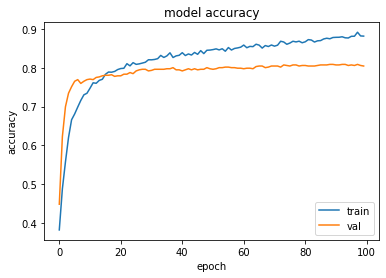

In [ ]:
# Performance of Inception v3 on BreakHis
import matplotlib.pyplot as plt
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

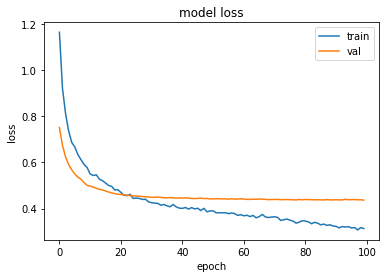

In [ ]:
# Performance of Inception v3 on BreakHis
import matplotlib.pyplot as plt
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
inception.evaluate(X_test,Y_test)

25/25 [==============================] - 2s 66ms/step - loss: 0.4774 - accuracy: 0.7712


[0.4773716330528259, 0.771175742149353]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = inception.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.69      0.61      0.65       274
   malignant       0.81      0.85      0.83       517

    accuracy                           0.77       791
   macro avg       0.75      0.73      0.74       791
weighted avg       0.77      0.77      0.77       791



In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))

array([[168, 106],
       [ 75, 442]])

In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))
#this is actually for next one

array([[200,  35],
       [ 43, 513]])

##Fully Trained

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(weights=None, include_top=False, input_shape=(128,128,3))

In [ ]:
for i, layer in enumerate(inception_v3.layers):
  print(i,layer.name, layer.trainable)

In [ ]:
inception = Sequential()
inception.add(inception_v3)
inception.add(Flatten())   # flatten output of conv
inception.add(BatchNormalization())
inception.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 128 neuron
inception.add(Dropout(0.5))
inception.add(BatchNormalization())
inception.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
inception.add(Dropout(0.5))
inception.add(Dense(2, activation='softmax'))  # output layer

In [ ]:
#this gave best 91 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)

In [ ]:
inception.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_4 = inception.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 29s 111ms/step - loss: 0.7166 - accuracy: 0.6758 - val_loss: 0.6355 - val_accuracy: 0.7121
Epoch 2/100
201/201 [==============================] - 21s 107ms/step - loss: 0.5100 - accuracy: 0.8082 - val_loss: 0.6318 - val_accuracy: 0.7542
Epoch 3/100
201/201 [==============================] - 21s 105ms/step - loss: 0.4690 - accuracy: 0.8271 - val_loss: 0.4964 - val_accuracy: 0.8329
Epoch 4/100
201/201 [==============================] - 21s 105ms/step - loss: 0.4171 - accuracy: 0.8317 - val_loss: 0.3679 - val_accuracy: 0.8441
Epoch 5/100
201/201 [==============================] - 21s 105ms/step - loss: 0.3989 - accuracy: 0.8343 - val_loss: 0.3602 - val_accuracy: 0.8455
Epoch 6/100
201/201 [==============================] - 21s 105ms/step - loss: 0.3799 - accuracy: 0.8440 - val_loss: 0.3516 - val_accuracy: 0.8511
Epoch 7/100
201/201 [==============================] - 21s 105ms/step - loss: 0.3560 - accuracy: 0.8500 - val_loss: 0.3417 -

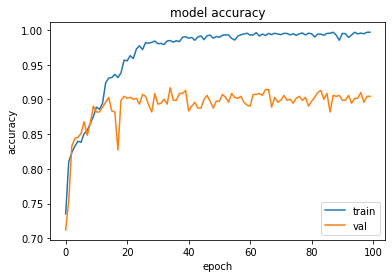

In [ ]:
# Performance of Inception v3 on BreakHis
import matplotlib.pyplot as plt
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

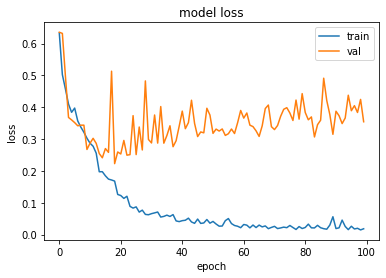

In [ ]:
# Performance of Inception v3 on BreakHis
import matplotlib.pyplot as plt
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
inception.evaluate(X_test,Y_test)

25/25 [==============================] - 1s 34ms/step - loss: 0.3552 - accuracy: 0.9014


[0.3552309274673462, 0.9013906717300415]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = inception.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.82      0.85      0.84       235
   malignant       0.94      0.92      0.93       556

    accuracy                           0.90       791
   macro avg       0.88      0.89      0.88       791
weighted avg       0.90      0.90      0.90       791



#VGG16


##Fine Tuned

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(Flatten())   # flatten output of conv
vgg16.add(BatchNormalization())
vgg16.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 128 neuron
vgg16.add(Dropout(0.5))
vgg16.add(BatchNormalization())
vgg16.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
vgg16.add(Dropout(0.5))
vgg16.add(Dense(2, activation='softmax'))  # output layer

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers[:11]:
  layer.trainable=False

In [ ]:
for i, layer in enumerate(vgg.layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 8192)              32768     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
for i, layer in enumerate(vgg16.layers):
  print(i,layer.name, layer.trainable)

0 vgg16 True
1 flatten True
2 batch_normalization True
3 dense True
4 dropout True
5 batch_normalization_1 True
6 dense_1 True
7 dropout_1 True
8 dense_2 True


In [ ]:
vgg16.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_5 = vgg16.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 64s 150ms/step - loss: 0.6884 - accuracy: 0.6760 - val_loss: 1.4638 - val_accuracy: 0.5899
Epoch 2/100
201/201 [==============================] - 27s 136ms/step - loss: 0.4618 - accuracy: 0.8037 - val_loss: 0.5917 - val_accuracy: 0.7416
Epoch 3/100
201/201 [==============================] - 27s 136ms/step - loss: 0.3412 - accuracy: 0.8779 - val_loss: 0.5500 - val_accuracy: 0.7823
Epoch 4/100
201/201 [==============================] - 27s 136ms/step - loss: 0.3222 - accuracy: 0.8782 - val_loss: 1.7060 - val_accuracy: 0.7135
Epoch 5/100
201/201 [==============================] - 27s 137ms/step - loss: 0.3179 - accuracy: 0.8799 - val_loss: 4.1285 - val_accuracy: 0.7121
Epoch 6/100
201/201 [==============================] - 27s 137ms/step - loss: 0.2863 - accuracy: 0.8940 - val_loss: 0.8366 - val_accuracy: 0.6924

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/100
201/201 [=======================

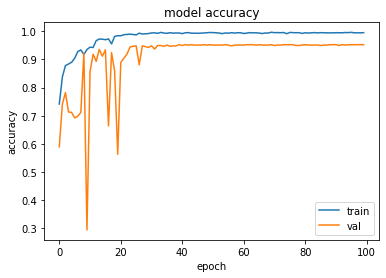

In [ ]:
# Performance of VGG16 on BreakHis 
import matplotlib.pyplot as plt
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

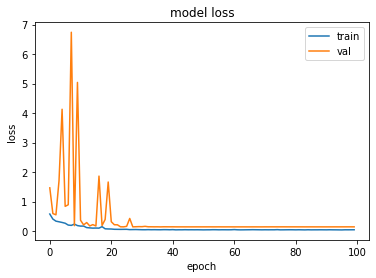

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
vgg16.evaluate(X_test,Y_test)

25/25 [==============================] - 5s 190ms/step - loss: 0.1089 - accuracy: 0.9608


[0.1089295819401741, 0.9608091115951538]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = vgg16.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.94      0.93      0.94       244
   malignant       0.97      0.97      0.97       547

    accuracy                           0.96       791
   macro avg       0.95      0.95      0.95       791
weighted avg       0.96      0.96      0.96       791



In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))

array([[228,  16],
       [ 15, 532]])

##Fully Trained

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, weights=None, input_shape=(128,128,3))
vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(Flatten())   # flatten output of conv
vgg16.add(BatchNormalization())
vgg16.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 127 neuron
vgg16.add(Dropout(0.5))
vgg16.add(BatchNormalization())
vgg16.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer of 64 neuron
vgg16.add(Dropout(0.5))
vgg16.add(Dense(2, activation='softmax'))  # output layer

In [ ]:
optimizer = tf.keras.optimizers.SGD(
          learning_rate=0.01)

In [ ]:
vgg16.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_5 = vgg16.fit(X_train, Y_train, batch_size=32, epochs = 100, validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Epoch 1/100
201/201 [==============================] - 37s 155ms/step - loss: 0.5889 - accuracy: 0.7162 - val_loss: 0.6401 - val_accuracy: 0.7121
Epoch 2/100
201/201 [==============================] - 29s 143ms/step - loss: 0.4940 - accuracy: 0.7927 - val_loss: 0.6487 - val_accuracy: 0.6629
Epoch 3/100
201/201 [==============================] - 28s 140ms/step - loss: 0.4722 - accuracy: 0.8044 - val_loss: 0.4884 - val_accuracy: 0.7528
Epoch 4/100
201/201 [==============================] - 28s 140ms/step - loss: 0.4444 - accuracy: 0.8227 - val_loss: 1.6850 - val_accuracy: 0.7121
Epoch 5/100
201/201 [==============================] - 28s 140ms/step - loss: 0.4547 - accuracy: 0.8164 - val_loss: 3.9859 - val_accuracy: 0.7149
Epoch 6/100
201/201 [==============================] - 28s 140ms/step - loss: 0.4496 - accuracy: 0.8137 - val_loss: 14.4715 - val_accuracy: 0.2879

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/100
201/201 [======================

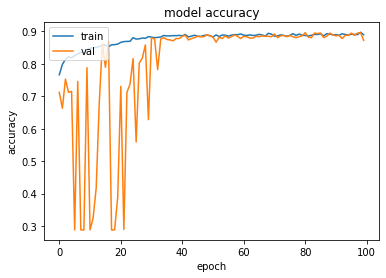

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

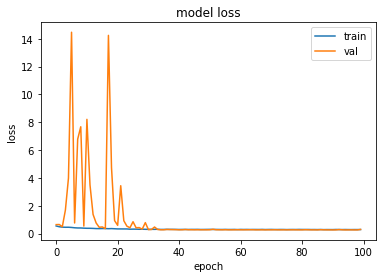

In [ ]:
# Performance of ResNet50 on BreakHis (100x magnifaction images)
import matplotlib.pyplot as plt
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
vgg16.evaluate(X_test,Y_test)

25/25 [==============================] - 3s 124ms/step - loss: 0.2671 - accuracy: 0.8951


[0.2670533061027527, 0.8950695395469666]

In [ ]:
from sklearn.metrics import classification_report
Y_pred = vgg16.predict(X_test)
print(classification_report(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1), target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.84      0.82      0.83       248
   malignant       0.92      0.93      0.92       543

    accuracy                           0.90       791
   macro avg       0.88      0.88      0.88       791
weighted avg       0.89      0.90      0.89       791



In [ ]:
confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1))

array([[204,  44],
       [ 39, 504]])

Things to do:
decrease the LR where you see fluctuations
pre-processing
hyper parameter tuning
epochs